### Poisson regression on COVID-19 time series dataset 

For Epidemiological time series datasets, Poisson regression and Poisson autoregressive regression models have been applied to various studies. Time series data from different countries (China, South Korea, Japan, Italy, Spain, France, UK, Germany, Netherlands, USA, and Greece) were retrieved from the kaggle website ("Novel Corona Virus 2019 Dataset", 2020 https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset). The Poisson regression model was fitted to a train set (2/3 of the dataset) and a test set (1/3 of the dataset).

In the case of the COVID-19 available time series dataset, the Poisson regression model did not seem to perform well. 


In [1]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

In [2]:
country_choise = 'Japan'    ######################change country
#In the available dataset the last day with available data is 23/03/2020
#I use the counted covid cases untill March 20, 2020, in order to test the precission of my model's prediction in the days (21-23/032020)
last_day = 3

In [4]:
data_input = pd.read_csv('time_series_covid_19_confirmed.csv',index_col='Country/Region')    

# Transpose the matrix and remove the columns Province/State, Lat, Long 
data_input = data_input.transpose().iloc[3:,:]  

# The dates are the index of each row, convert the dates to DatetimeIndex format
data_input.index = pd.to_datetime(data_input.index)
dataset = data_input.groupby(data_input.columns, axis=1).sum()

df = dataset[country_choise][:-last_day].to_frame()    ## not to include the data after 23/3, in a data frame

ds = df.index.to_series()
df['MONTH'] = ds.dt.month
df['DAY'] = ds.dt.day

df_train, df_test = train_test_split(df, test_size=0.3, random_state=43)
#mask = np.random.rand(len(df)) < 0.8
#df_train = df[mask]
#df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))
#print(df_test)
expr = """Japan ~ MONTH + DAY"""      ######################change country

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

Training data set length=41
Testing data set length=18


In [5]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_training_results.summary())

poisson_predictions = poisson_training_results.get_prediction(X_test)
predictions_summary_frame = poisson_predictions.summary_frame()
print(poisson_predictions)
print(predictions_summary_frame)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Japan   No. Observations:                   41
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -251.36
Date:                Tue, 15 Mar 2022   Deviance:                       249.06
Time:                        15:08:14   Pearson chi2:                     233.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9291      0.090    -21.387      0.0

In [6]:
dates_fc = pd.to_datetime(['2020-3-21', '2020-3-22', '2020-3-23', '2020-3-24', '2020-3-25', '2020-3-26'])
month = [3, 3, 3, 3, 3, 3]
day = [21, 22, 23, 24, 25, 26]
intercept = [1, 1, 1, 1, 1, 1]
d = {'Intercept': intercept, 'MONTH':month, 'DAY':day}

df_fc = pd.DataFrame(data = d, index = dates_fc)
#print(df_fc)
#print(type(df_fc.index))

predictions = poisson_training_results.predict(df_fc)
print(predictions)

2020-03-21    1194.275994
2020-03-22    1286.300424
2020-03-23    1385.415758
2020-03-24    1492.168382
2020-03-25    1607.146784
2020-03-26    1730.984798
dtype: float64


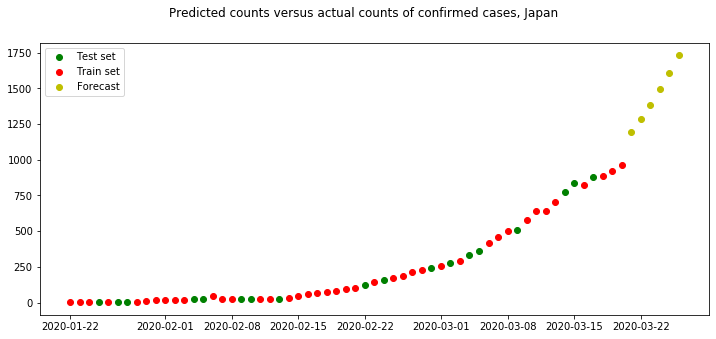

In [7]:
actual_counts = y_train[country_choise]    
y = y_test[country_choise]

fig = plt.figure(figsize=(12,5))
fig.suptitle('Predicted counts versus actual counts of confirmed cases, ' + country_choise)
predicted, = plt.plot(X_test.index, y, 'go', label='Test set')
actual, = plt.plot(X_train.index, actual_counts, 'ro', label='Train set')
future, = plt.plot(predictions.index, predictions, 'yo', label='Forecast')

plt.legend(handles=[predicted, actual, future])
plt.show()